In [8]:
#pip install matplotlib control

In [23]:
from pylab import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
import control
from time import sleep
import math
import time
from pprint import pprint

import SoapySDR as sp


In [10]:
args = dict(driver="sdrplay")
sdr = sp.Device(args)

[INFO] devIdx: 0
[INFO] SerNo: B0001P0004
[INFO] hwVer: 1
[INFO] rspDuoMode: 0
[INFO] tuner: 1
[INFO] rspDuoSampleFreq: 0.000000


In [37]:
def fazer_aquisicao(sample_rate, center_freq, gain, nsamples, verbose: bool = False):
    if sample_rate < 1e6:
        if verbose: print("sample_rate precisa estar entre 1e6 e 2e6")
        return
    if gain < 1:
        if verbose: print("gain precisa ser maior igual a 1")
   
    args = dict(driver="sdrplay")
    sdr = sp.Device(args)
    rx_chan = 0
    gain = 42 - gain
    sdr.setSampleRate(sp.SOAPY_SDR_RX, rx_chan, sample_rate)
    sdr.setFrequency(sp.SOAPY_SDR_RX, rx_chan, center_freq)
    sdr.setGainMode(sp.SOAPY_SDR_RX, rx_chan, False) # turn off AGC
    sdr.setGain(sp.SOAPY_SDR_RX, rx_chan, gain)
   
    max_nsamples = 32256
    rodadas = 1
    if nsamples > max_nsamples:
        rodadas = math.ceil(nsamples/max_nsamples)

    if verbose: print("[INFO]Para", nsamples, "serão feitas", rodadas, "medidas")
    rxStream = sdr.setupStream(sp.SOAPY_SDR_RX, sp.SOAPY_SDR_CF32)
    if verbose: print("faxa de ganho")
    if verbose: print(sdr.getGainRange(sp.SOAPY_SDR_RX, rx_chan))
    
    if verbose: print("[DONE]setup")
    
    sdr.activateStream(rxStream) #start streaming
    if verbose: print("[DONE]activateStream")
    
    _samples = np.array([0]*max_nsamples, np.complex64)
    samples = np.array([], np.complex64)
    mperdidas = 0;
    t0 = time.time()
    for j in range(rodadas):        
        for i in range(20):
            sr = sdr.readStream(rxStream, [_samples], len(_samples))
            if sr.ret > 0:                
                break
            if i == 19:
                mperdidas = mperdidas + 1
                print("[ERROR]readStream", sr.ret)
                print("[INFO]", mperdidas, "/", rodadas, "medidas perdidas")
                break
        samples = np.concatenate([samples, _samples])
    t1 = time.time()
    if verbose: print("Aquisição demorou", t1-t0, "s")
    sdr.deactivateStream(rxStream) #stop streaming
    sdr.closeStream(rxStream)
    sleep(1)
    if verbose: print("[DONE]fechou")
    return samples

def fazer_grafico(samples, sample_rate, center_freq, verbose: bool = False):
    if sample_rate < 1e6:
        if verbose: print("sample_rate precisa ser maior igual a 1e6")
        return
    if center_freq < 1e6:
        if verbose: print("center_freq precisa ser maior igual a 1e6")
        return    
    NFFT = 1024
    plt.figure()
    plt.psd(samples, NFFT=NFFT, Fs=sample_rate/1e6, Fc=center_freq/1e6, color='crimson')    
    
    xlabel('Frequency (MHz)')
    ylabel('Relative power (dB)') 
    #plt.savefig("psd.png")
    
def obter_magnitude(freq, samples, sample_rate, center_freq, verbose: bool = False):
    if sample_rate < 1e6:
        if verbose: print("sample_rate precisa ser maior igual a 1e6")
        return
    if center_freq < 1e6:
        if verbose: print("center_freq precisa ser maior igual a 1e6")
        return
    sample_rate = sample_rate/1e6
    center_freq = center_freq/1e6
    freq = freq/1e6
    NFFT = 1024
    axes = psd(samples, NFFT=NFFT, Fs=sample_rate)
    y = 10*np.log10(axes[0])
    x = axes[1] + center_freq
    if verbose: print(f'A aplitude máxima é {y.max()}')
    i = find_nearest(x, freq)    
    return x[i],y[i]

def obter_magnitude_max(freq, samples, sample_rate, center_freq, verbose: bool = False):
    if sample_rate < 1e6:
        if verbose: print("sample_rate precisa ser maior igual a 1e6")
        return
    if center_freq < 1e6:
        if verbose: print("center_freq precisa ser maior igual a 1e6")
        return
    sample_rate = sample_rate/1e6
    center_freq = center_freq/1e6
    freq = freq/1e6
    NFFT = 1024
    axes = psd(samples, NFFT=NFFT, Fs=sample_rate)
    y = 10*np.log10(axes[0])
    x = axes[1] + center_freq
    
    max_freq = y.max()
    i = find_nearest(y, max_freq) 
    if verbose: print(f'A aplitude máxima é {max_freq}', x[i], y[i])
       
    return x[i], y[i]

def find_nearest(array, value):
    #https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def obter_magnitude_sem_ganho(mag, ganho):
    amp = control.db2mag(mag)/ganho
    return 20*np.log10(amp)

[10.2, 20.2, 30.2, 40.2, 50.2, 60.2, 70.2, 80.2, 90.2]

In [136]:
sample_rate = 1e6
#center_freq = 5.2e6
measurement_time = 0.2 #o SDR demora sempre +-60ms a mais
gain = 0
#freq_list = [f+0.2 for f in range(10, 210, 10)] # in MHz
freq_list = [10.2]*10
amplitude_list = [] # in dB

t0 = time.time()
for i in range(len(freq_list)):
    center_freq = freq_list[i]*1e6
    samples = fazer_aquisicao(
        sample_rate = sample_rate,
        center_freq = center_freq,
        gain = gain,
        nsamples = int(measurement_time*sample_rate),
    )

    #fazer_grafico(
    #    samples = samples,
    #    sample_rate = sample_rate,
    #    center_freq = center_freq
    #)
    freq, mag = obter_magnitude_max(
        freq = center_freq,
        samples = samples,
        sample_rate = sample_rate,
        center_freq = center_freq,
    )
    amplitude_list.append(mag)
    #print("Na frequência", freq, "a magnitude é de", mag, "dB")
t1 = time.time()
print(f'Total execution time: {t1-t0}s')
pprint(dict(zip(freq_list, amplitude_list)))
for a in amplitude_list:
    print(a)

[INFO] Using format CF32.
[INFO] Using format CF32.
[INFO] Using format CF32.
[INFO] Using format CF32.
[INFO] Using format CF32.
[INFO] Using format CF32.
[INFO] Using format CF32.
[INFO] Using format CF32.
[INFO] Using format CF32.
[INFO] Using format CF32.


Total execution time: 17.648067235946655s
{10.2: -29.897048354481356}
-29.665485071694114
-29.792147005620034
-29.79457392272048
-29.793379403931848
-29.791239821398143
-29.843527201316704
-29.841913389416774
-29.85884369895363
-29.880079020406136
-29.897048354481356


[INFO] Using format CF32.


Na frequência 24.9998046875 a magnitude é de -27.596364144586296 dB


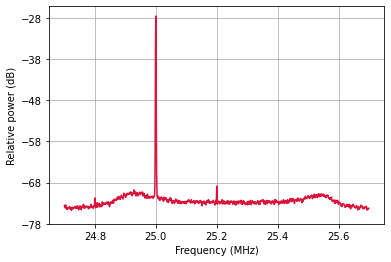

In [117]:
sample_rate = 1e6
center_freq = 25.2e6
measurement_time = 0.2 #o SDR demora sempre +-60ms a mais
gain = 0

samples = fazer_aquisicao(
    sample_rate = sample_rate,
    center_freq = center_freq,
    gain = gain,
    nsamples = int(measurement_time*sample_rate),
)

fazer_grafico(
    samples = samples,
    sample_rate = sample_rate,
    center_freq = center_freq
)
freq, mag = obter_magnitude_max(
    freq = center_freq,
    samples = samples,
    sample_rate = sample_rate,
    center_freq = center_freq,
)
print("Na frequência", freq, "a magnitude é de", mag, "dB")

In [119]:
[print(a) for a in amplitude_list]; #ganho 0

-29.890766914141413
-68.84513416754713
-40.502898799213575
-69.21953271393991
-45.80724446096756
-63.02998670657509
-37.718198874374494
-64.95207997997075
-57.560440912667225
-69.01667688066654
-69.08837065729995
-65.59777416346287
-59.71239988187335
-64.13612297976124
-59.31593615740547
-68.86317994986057
-69.10991008454708
-69.11594311224422
-69.18131666599798
